# Plotting the Accerleration Mismatch

The following code generates Figure 11 (a)

In [1]:
import os
os.chdir(f'{os.getcwd()}/../../')
WORKING_DIR = './evaluation/uspc'

In [4]:
import pandas
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm

from utils3d import fibonacci_sphere
from utils3d import cartesian_to_spherical

import seaborn as sns
from matplotlib import pyplot as plt
sns.set(color_codes=True)

In [3]:
def eval_acc_error(acc_grid, anchors):
    SPACE_SIZE = 10
    N_RND_SAMPLES = 1000 * 1000
    
    gv = acc_grid.shape[0]
    n_anchors = anchors.shape[0]
    
    # Random sample
    p_rnd = (np.random.rand(N_RND_SAMPLES, 3) * 2 - 1) * np.random.rand(N_RND_SAMPLES, 1) * SPACE_SIZE
    p_len = np.linalg.norm(p_rnd, axis=-1, keepdims=True)
    p_rnd = p_rnd / p_len
    gt = np.argmax(p_rnd @ anchors.transpose(), axis=-1)
    
    p_rnd_sph = cartesian_to_spherical(p_rnd)
    p_rnd_sph_theta = p_rnd_sph[:, 0]
    p_rnd_sph_phi = p_rnd_sph[:, 1]
    
    p_rnd_cu = np.round(np.degrees(p_rnd_sph_phi) % 360 / 360 * (gv * 2 - 1)).astype(np.int)
    p_rnd_cv = np.round(np.degrees(p_rnd_sph_theta) / 180 * (gv - 1)).astype(np.int)
    p_rnd_cuv = np.stack((p_rnd_cu, p_rnd_cv), axis=-1)
    
    pd = acc_grid[p_rnd_cuv[:, 1], p_rnd_cuv[:, 0]]
    
    match = gt == pd
    acc = match.sum() / match.shape[0]
    
    return acc

In [6]:
anchors_group = [fibonacci_sphere(v) for v in [512, 768, 1024, 1280, 1536, 1792, 2048]]
v_acc_grid_group = [256, 512, 768, 1024]
df = pd.DataFrame(columns=['anchors', 'grid_height', 'accuracy'])

In [7]:
for anchors in tqdm(anchors_group):
    for v_acc_grid in tqdm(v_acc_grid_group):
        n_anchors = anchors.shape[0]
        
        acc_grid = np.frombuffer(
            open(f'{WORKING_DIR}/data/grid_{n_anchors}_{v_acc_grid * 2}_{v_acc_grid}.bytes', 'rb').read(), 
            dtype=np.uint32
        ).reshape((v_acc_grid, -1))
        
        accuracy = eval_acc_error(acc_grid, anchors)
        
        df.loc[len(df)] = [n_anchors, v_acc_grid, accuracy]

100%|██████████| 7/7 [04:02<00:00, 34.59s/it]


In [8]:
df.to_csv(f'{WORKING_DIR}/results/acc_error.csv')

# Evaluating Error

In [5]:
df = pd.read_csv(f'{WORKING_DIR}/results/acc_error.csv')

In [6]:
df['error'] = 1 - df['accuracy']

In [7]:
df['grid_size'] = (df['grid_height'].astype(int) * 2).astype(str) + 'x' + df['grid_height'].astype(int).astype(str)

<ipython-input-26-2058c6b70e95>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([256 + 256 * v for v in range(8)], size=14)
<ipython-input-26-2058c6b70e95>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.around(ax.get_yticks(), decimals=2), size=16)


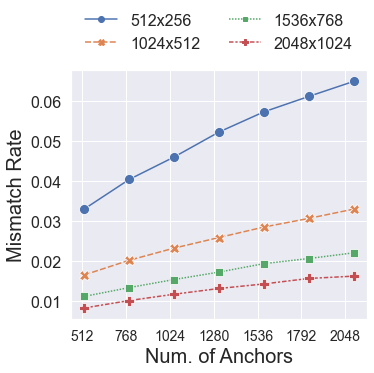

In [26]:
plt.figure(figsize=(5, 5))

ax = sns.lineplot(data=df, style='grid_size', hue='grid_size', x='anchors', y='error',  markers=True, markersize=10)

ax.legend(
    loc='lower center', fontsize=16, ncol=2,
    bbox_to_anchor=(0., 1.02, 1., .102), mode='expand',
    edgecolor=(0, 0, 0, 0),
    facecolor=(0, 0, 1, 0.0)
).get_frame().set_alpha(None)

ax.set_xlabel('Num. of Anchors', fontsize=20)
ax.set_ylabel('Mismatch Rate', fontsize=20)

plt.setp(ax.get_legend().get_texts(), fontsize='16') # for legend text

ax.set_xticklabels([256 + 256 * v for v in range(8)], size=14)
ax.set_yticklabels(np.around(ax.get_yticks(), decimals=2), size=16)

plt.tight_layout(pad=0)
plt.savefig(f'{WORKING_DIR}/figures/acceleration_mismatch.pdf')